In [1]:
import duckdb

conn = duckdb.connect("duckdb.db")

In [2]:
from jinja2 import Template

with open('performance_summary.sql') as f:
    template = Template(f.read())

In [3]:
conn.execute("select count(*) from 'data/acq.parquet';").fetchdf()

,count_star()
0,37015214


In [4]:
conn.execute("select count(*) from 'data/perf.parquet';").fetchdf()

,count_star()
0,1890353680


In [11]:
conn.execute("""PRAGMA enable_profiling='json';
PRAGMA profile_output='profile2.json';""")

print(template.render(perf='data/perf.parquet', 
                                       acq='data/acq.parquet'))

WITH performance AS (
    SELECT
        perf.loan_id,
        book.orig_date,
        perf.loan_age AS stmt_number,
        book.borrower_credit_score,
        perf.disposition_date,
        perf.current_actual_upb,
        strftime(
            strptime(perf.monthly_reporting_period, '%Y-%d-%m'), '%Y-%m'
        ) AS report_month,
        CASE
            WHEN perf.current_loan_delinquency_status > 1 THEN 1
            ELSE 0
        END AS dq30,
        CASE
            WHEN perf.current_loan_delinquency_status > 3 THEN 1
            ELSE 0
        END AS dq90,
        CASE
            WHEN perf.current_loan_delinquency_status > 6 THEN 1
            ELSE 0
        END AS dq180,
        CASE
            WHEN perf.zero_balance_code = '02' THEN 1
            WHEN perf.zero_balance_code = '03' THEN 1
            WHEN perf.zero_balance_code = '09' THEN 1
            WHEN perf.zero_balance_code = '15' THEN 1
            ELSE 0
        END AS bad
    FROM
        "data/perf.parquet" AS per

In [6]:
%%time
summary = conn.execute(template.render(perf='data/perf.parquet', 
                                       acq='data/acq.parquet')).fetchdf()

CPU times: user 50min 7s, sys: 3min 53s, total: 54min
Wall time: 9min 2s


In [13]:
summary

,orig_date,stmt_number,loan_count,avg_credit_score,upb_sum,dollar_bad
0,2003,19.0,5107349,731.103310,6.014418e+11,25973099.05
1,2015,12.0,1859767,754.180962,3.762418e+11,905599.17
2,2007,91.0,1252500,696.566081,3.387466e+10,89972905.79
3,2003,1.0,5107349,729.628530,1.543691e+09,0.00
4,2015,13.0,1859767,754.232290,3.702453e+11,2460711.38
...,...,...,...,...,...,...
2251,2012,69.0,2680141,770.612153,3.065800e+10,0.00
2252,2012,66.0,2680141,769.964599,8.499493e+10,87658.00
2253,2012,70.0,2680141,769.715452,1.317821e+10,0.00
2254,2012,67.0,2680141,770.412095,6.678450e+10,0.00


In [1]:
import json
import random

with open('profile.json') as f:
    profile = json.loads(f.read())

In [2]:
from graphviz import Digraph

In [3]:
def plot_plan(nested_json):
    
    out = Digraph(node_attr={'shape': 'box'})
    
    def plot(x, pre=''):
        if type(x) is dict:
            r = random.random() #WTF
            label=f'''<<TABLE>
                         <TR>
                           <TD>{x['name']}</TD>
                           <TD>{x['cardinality']}</TD>
                         </TR>
                      </TABLE>>'''
            out.node(x['name']+ str(r),label)
            if pre != '':
                out.edge(pre, x['name']+str(r))
                
            plot(x['children'], x['name']+str(r))
        elif type(x) is list:
            for each in x:
                plot(each,pre)
                
    plot(nested_json)  
    return out

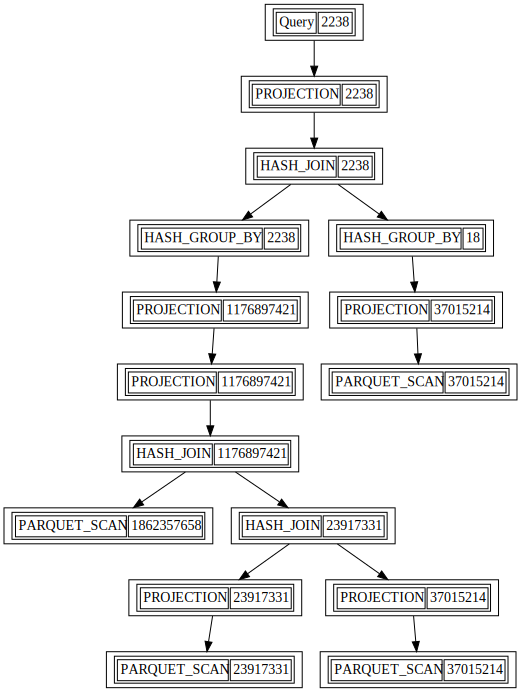

In [4]:
plot_plan(profile)

In [35]:
summary.head()

,orig_date,stmt_number,loan_count,avg_credit_score,dq30_count,dq90_count,dq180_count,upb_sum,bad_cnt,dollar_bad
0,2003,1.0,5107349,730.250014,3.0,0.0,0.0,1.539525e+09,0.0,0.00
1,2015,12.0,1859767,754.268143,1737.0,653.0,219.0,2.792753e+11,4.0,610859.83
2,2007,12.0,1252500,719.906212,10093.0,4207.0,1570.0,1.180344e+11,85.0,15810272.64
3,2003,2.0,5107349,730.238309,2193.0,0.0,0.0,3.354519e+09,0.0,0.00
4,2015,1.0,1859767,754.146714,0.0,0.0,0.0,3.798550e+08,0.0,0.00


In [38]:
summary.groupby('orig_date').dollar_bad.sum()/summary.groupby('orig_date').upb_sum.max()

orig_date
1999    0.010162
2000    0.008756
2001    0.007439
2002    0.007903
2003    0.011534
2004    0.024403
2005    0.054939
2006    0.076471
2007    0.085242
2008    0.042009
2009    0.005343
2010    0.001708
2011    0.001052
2012    0.000468
2013    0.000466
2014    0.000451
2015    0.000124
2016    0.000011
dtype: float64